In [13]:
import pandas as pd
from matplotlib import pyplot as plt
import fastf1
import fastf1.plotting
import matplotlib as mpl
from matplotlib.collections import LineCollection
import numpy as np
import seaborn as sns

In [3]:
session_monza = fastf1.get_session(2023, 'monza', 'R')
session_monza.load()

session_melbourne = fastf1.get_session(2023, 'melbourne', 'R')
session_melbourne.load()



req         WARNING 	DEFAULT CACHE ENABLED! (453.46 MB) /Users/vincentparra/Library/Caches/fastf1
core           INFO 	Loading data for Italian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 1 completed the race distance 06:25.888000 before the recorded end of the session.
core        WARNING 	Driver 1

In [4]:
lap_monza_nor = session_monza.laps.pick_drivers('NOR').pick_fastest()

laps_monza = session_monza.laps

stints = laps_monza[['Driver', 'Stint', 'Compound', 'LapNumber']]
stints = stints.groupby(['Driver', 'Stint', 'Compound'])
stints = stints.count().reset_index()
stints = stints.rename(columns={'LapNumber': 'StintLength'})

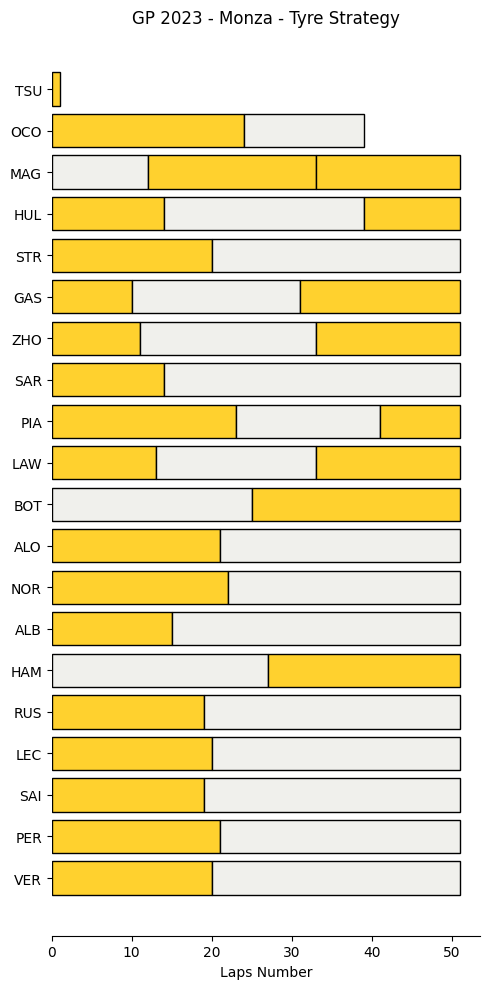

In [5]:
drivers = session_monza.drivers

drivers = [session_monza.get_driver(driver)["Abbreviation"] for driver in drivers]


fig, ax = plt.subplots(figsize=(5, 10))

for driver in drivers:
    driver_stints = stints.loc[stints['Driver'] == driver]

    previous_stint_end = 0
    for idx, row in driver_stints.iterrows():
        compound_color = fastf1.plotting.get_compound_color(row['Compound'], session=session_monza)
        plt.barh(y=driver,
        width=row['StintLength'], 
        left=previous_stint_end, 
        color=compound_color,
        edgecolor='black',
        fill=True)
        previous_stint_end += row["StintLength"]

plt.title('GP 2023 - Monza - Tyre Strategy')
plt.xlabel('Laps Number')
plt.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.tight_layout()
plt.show()

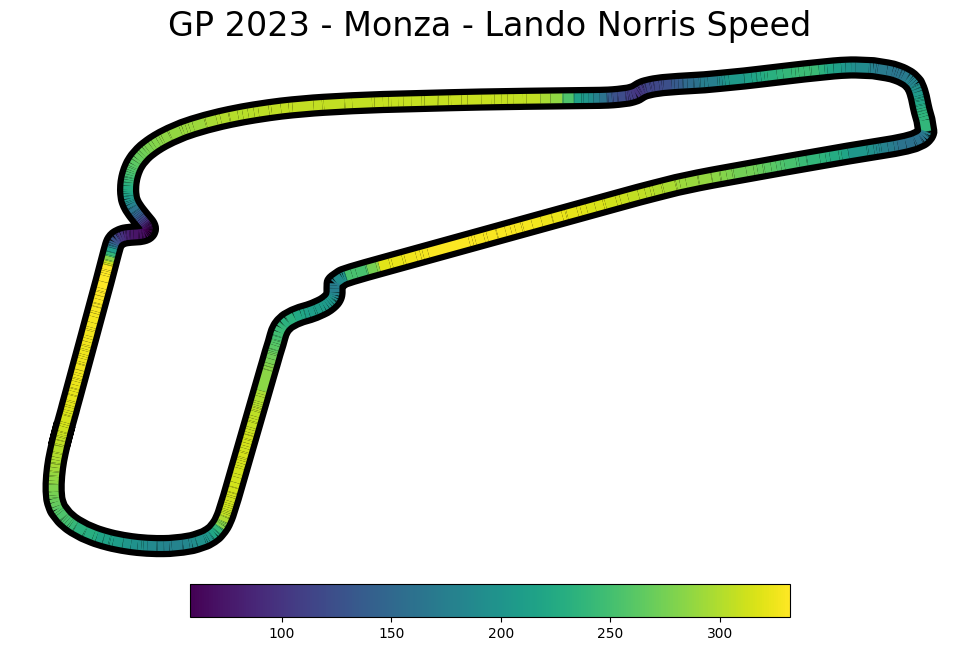

In [6]:
x_monza = lap_monza_nor.telemetry['X']
y_monza = lap_monza_nor.telemetry['Y']
color = lap_monza_nor.telemetry['Speed']

colormap = mpl.cm.viridis

points = np.array([x_monza, y_monza]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

fig, ax = plt.subplots(sharex=True, sharey=True, figsize=(12, 6.75))
fig.suptitle('GP 2023 - Monza - Lando Norris Speed', size=24, y=0.95)

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.12)
ax.axis('off')

ax.plot(x_monza, y_monza, color='black', linewidth=16, zorder=0)

norm = plt.Normalize(color.min(), color.max())
lc = LineCollection(segments, cmap=colormap, norm=norm, linewidth=7)

lc.set_array(color)
line = ax.add_collection(lc)

cbaxes = fig.add_axes([0.25, 0.05, 0.5, 0.05])
normlegend = mpl.colors.Normalize(vmin=color.min(), vmax=color.max())
legend = mpl.colorbar.ColorbarBase(cbaxes, norm=normlegend, cmap=colormap, orientation='horizontal')

plt.show()

Text(0.5, 1.0, 'Melbourne')

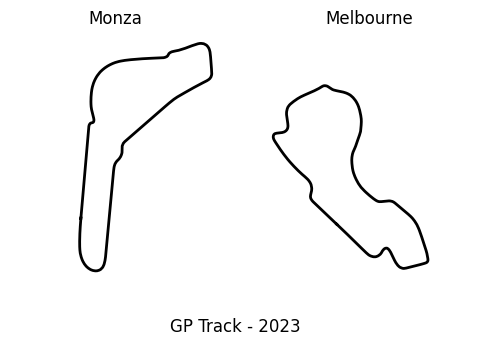

In [7]:
# différence de circuit
# Cette partie sert à expliqué l'importance d'avoir un modèle par circuit
# L'usure des pneus ainsi que les stratégies vont donc différés


x_mel = session_melbourne.laps.pick_drivers('NOR').pick_fastest().telemetry['X']
y_mel = session_melbourne.laps.pick_drivers('NOR').pick_fastest().telemetry['Y']

points_mel = np.array([x_mel, y_mel]).T.reshape(-1, 1, 2)
segments_mel = np.concatenate([points[:-1], points[1:]], axis=1)

fig, ax = plt.subplots(1,2, sharex=True, sharey=True, figsize=(6, 3.25))
fig.suptitle('GP Track - 2023', size=12, y=0)

ax[0].axis('off')
ax[0].plot(x_monza, y_monza, color='black', linewidth=2, zorder=0)
ax[0].set_title('Monza')
ax[1].axis('off')
ax[1].plot(x_mel, y_mel, color='black', linewidth=2, zorder=0)
ax[1].set_title('Melbourne')

In [10]:
data_monza = laps_monza[['Driver', 'Stint', 'Compound', 'LapNumber', 'LapTime', 'Position']]


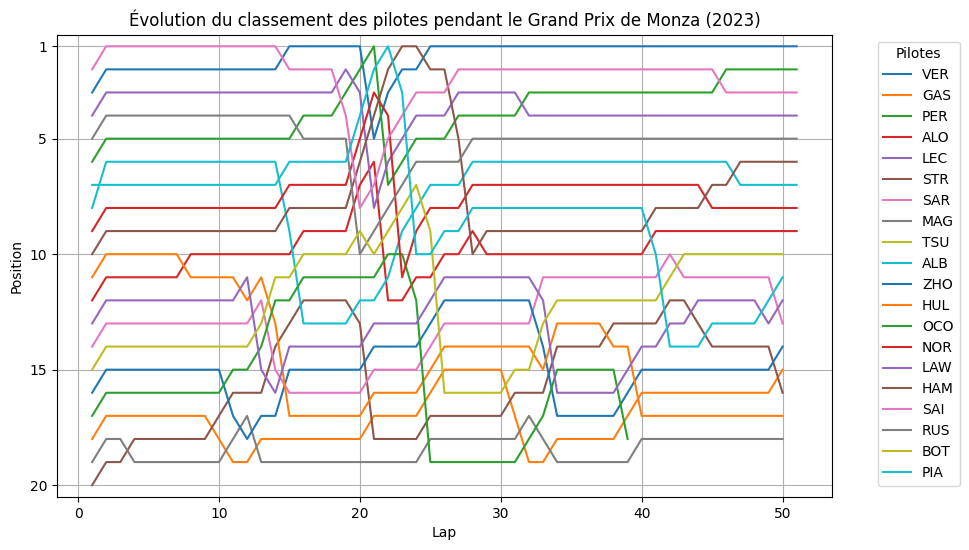

In [28]:
fig, ax = plt.subplots(figsize=(10, 6))

# Boucle pour chaque pilote et tracé de sa position pendant la course
for driver in data_monza['Driver'].unique():
    driver_data = data_monza[data_monza['Driver'] == driver]
    plt.plot(driver_data['LapNumber'], driver_data['Position'], label=driver)

plt.title("Évolution du classement des pilotes pendant le Grand Prix de Monza (2023)")
plt.xlabel("Numéro du tour")
plt.ylabel("Position")
plt.legend(title="Pilotes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
ax.set_ylim([20.5, 0.5])
ax.set_yticks([1, 5, 10, 15, 20])
ax.set_xlabel('Lap')
ax.set_ylabel('Position')
plt.show()

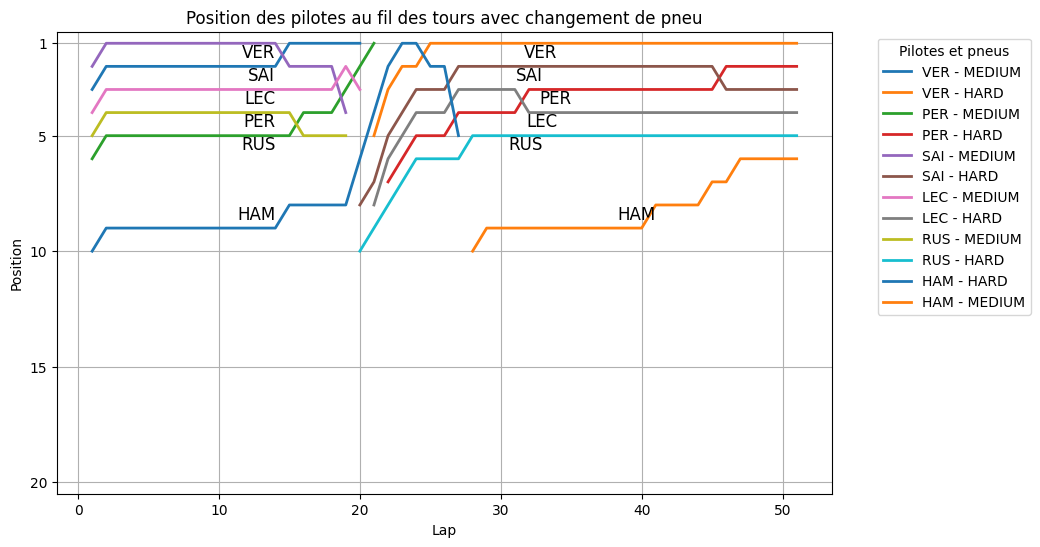

In [46]:
fig, ax = plt.subplots(figsize=(10, 6))
drivers = session_monza.drivers[:6]
drivers_monza_picks = [session_monza.get_driver(driver)["Abbreviation"] for driver in drivers]
for driver in drivers_monza_picks:
    driver_data = laps_monza[laps_monza['Driver'] == driver]
    
    for compound in driver_data['Compound'].unique():
        compound_data = driver_data[driver_data['Compound'] == compound]
        plt.plot(compound_data['LapNumber'], compound_data['Position'], label=f"{driver} - {compound}", linewidth=2)
        last_lap = compound_data['LapNumber'].iloc[13]
        last_position = compound_data['Position'].iloc[15]
        plt.text(last_lap, last_position, f"{driver}", fontsize=12, ha='right', va='top')
plt.title("Position des pilotes au fil des tours avec changement de pneu")
plt.xlabel("Numéro du tour")
plt.ylabel("Position")
plt.legend(title="Pilotes et pneus", bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_ylim([20.5, 0.5])
ax.set_yticks([1, 5, 10, 15, 20])
ax.set_xlabel('Lap')
ax.set_ylabel('Position')
plt.grid(True)
plt.show()